# Project: Investigate TMDb 10K Movie Dataset
*<span style="font-family:Arial; font-size:1.3em;">By: Redi Sunarta - Udacity Student (2020)</span>*

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
---
In this project, I choose the **TMDb movie data**. This data set contains information about more than 10,000 movies collected from The Movie Database (TMDb). Dataset contains massive movie information such as user ratings, cast, revenue, budget, etc. It makes me interested to understand what are the important factors that make a movie successful. In the context of this dataset, I can define 'success' in two ways. First, how the audience rates the film (subjective movie quality). The second one is simply the profit from the film's production (commercially). Therefore, we can raise several questions like *are there certain companies more likely produce successful movie? Is popularity equals to the success of a movie? Does a large filmmaking budget guarantee the success of the film? nor look a trend, how the quality of the film from year to year? compare to another variable?* Next section, I will try to answere these questions in order to complete the submission.

In [1]:
# import statements for all of the packages needed
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling
---
### General Properties

In [2]:
#load the data
path = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd1c4c_tmdb-movies/tmdb-movies.csv'
data = pd.read_csv(path)
data.sample(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
1629,13576,tt1477715,0.405828,60000000,0,Michael Jackson's This Is It,Michael Jackson|Orianthi|Kenny Ortega|Dorian H...,http://www.thisisit-movie.com,Kenny Ortega,Like You've Never Seen Him Before,...,"A compilation of interviews, rehearsals and ba...",111,Music|Documentary,Columbia Pictures,10/28/09,156,6.6,2009,6.098403e+07,0.000000e+00
2774,11845,tt0256103,0.362592,0,0,Intimacy,Mark Rylance|Kerry Fox|Timothy Spall|Alastair ...,NaN,Patrice ChÃ©reau,Every Wednesday. She meets him once a week.,...,"Jay, a failed musician, walked out of his fami...",119,Romance|Drama,NaN,1/20/01,15,6.5,2001,0.000000e+00,0.000000e+00
1829,24438,tt1314228,0.145905,58000000,85280250,Did You Hear About The Morgans?,Hugh Grant|Sarah Jessica Parker|Mary Steenburg...,NaN,Marc Lawrence,We're not in Manhattan anymore.,...,"In New York City, an estranged couple who witn...",103,Comedy,Columbia Pictures|Castle Rock Entertainment|Re...,12/17/09,181,5.0,2009,5.895123e+07,8.667888e+07


In [3]:
#check data shape, missingness and data type each column
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    10866 non-null  int64  
 1   imdb_id               10856 non-null  object 
 2   popularity            10866 non-null  float64
 3   budget                10866 non-null  int64  
 4   revenue               10866 non-null  int64  
 5   original_title        10866 non-null  object 
 6   cast                  10790 non-null  object 
 7   homepage              2936 non-null   object 
 8   director              10822 non-null  object 
 9   tagline               8042 non-null   object 
 10  keywords              9373 non-null   object 
 11  overview              10862 non-null  object 
 12  runtime               10866 non-null  int64  
 13  genres                10843 non-null  object 
 14  production_companies  9836 non-null   object 
 15  release_date       

In [4]:
# I prefer use adjusted the budget and revenue because accounting for inflation over time.
## The actual missingness of revenue_adj and budget_adj column
rev, budg = data.revenue_adj.value_counts()/len(data), data.budget_adj.value_counts()/len(data)

# Where rev/budget equal to zero
rev[0], budg[0]

(0.5536535983802687, 0.5242039388919566)

> If I check the missingness our target variables (vote_average and revenue_adj), it look like zero missing values in those two columns. However, after I read data documentation, it was necessary to treat values of zero in the revenues field as missing which mean revenue column have large missing values, up to 55.4%. Thus, I decide to choose vote_average columns as my only target variable. 

> Yet, vote_average value won't be fair since several movies have high average vote score even though small number of voter. Therefore, It will appropriate if I transform vote_score columns using [IMDB's weighted rating.](https://help.imdb.com/article/imdb/track-movies-tv/ratings-faq/G67Y87TFYYP6TWAV#calculatetop)

$$\text{Weight Rating (WR)} = \left(\frac{\nu}{\nu + m} \cdot \text{R}\right) + \left(\frac{m}{\nu + m} \cdot \text{C} \right)$$

   <p style="text-align: center;">R: average rating for whole movie.</p>
   <p style="text-align: center;">v: number of votes for the movie.</p>
   <p style="text-align: center;">m: minimum votes required.</p>
   <p style="text-align: center;">C: the mean vote across the whole report.</p>

In [5]:
C = data['vote_average'].mean()
m = 30 #our minimum votes required --based on rule of thumb
movie = data.copy().loc[data['vote_count'] >= m]

In [6]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

movie['quality_score'] = movie.apply(weighted_rating, axis=1)
movie.sample(5)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,quality_score
7270,10669,tt0068473,0.949381,2000000,46122355,Deliverance,Jon Voight|Burt Reynolds|Ned Beatty|Ronny Cox|...,NaN,John Boorman,What did happen on the Cahulawassee River?,...,109,Drama|Adventure|Thriller,Warner Bros.|Elmer Enterprises,7/30/72,209,7.0,1972,1.042912e+07,2.405078e+08,6.871329
2589,16406,tt0144168,0.187319,13000000,27500000,Dick,Kirsten Dunst|Michelle Williams|Will Ferrell|D...,NaN,Andrew Fleming,The unmaking of the president,...,94,Comedy,Columbia Pictures,8/4/99,33,5.7,1999,1.701769e+07,3.599895e+07,5.830915
162,252512,tt1791682,0.937620,10000000,7587485,While We're Young,Ben Stiller|Naomi Watts|Adam Driver|Amanda Sey...,NaN,Noah Baumbach,Life Never Gets Old.,...,97,Drama|Comedy,Scott Rudin Productions|A24,3/27/15,265,5.9,2015,9.199996e+06,6.980483e+06,5.907619
8356,14603,tt0104647,0.153994,0,0,Kuffs,Christian Slater|Milla Jovovich|Tony Goldwyn|B...,NaN,Bruce A. Evans,When you have attitude who needs experience?,...,102,Action|Comedy|Crime,Universal Pictures|Dino de Laurentiis Communic...,1/10/92,30,5.5,1992,0.000000e+00,0.000000e+00,5.737461
7693,17097,tt0465375,0.233575,825000,0,After Sex,Mila Kunis|Dave Franco|Jose Pablo Cantillo|Jan...,NaN,Eric Amadio,Eight Couples. One Conversation.,...,78,Comedy|Romance,NALA Films|Supino Pictures,9/26/07,32,5.3,2007,8.676266e+05,0.000000e+00,5.626575


In [7]:
movie.shape

(6144, 22)

### Data Cleaning
Based on exploration question, I don't necessarily use all column. In minimal term, I just need five columns to be cleaned, which is *score, budget_adj, popularity, production_companies, and release_year*. Thus, let's focus on it. 

General properties section before show me at least three, as follow:
   1. The budget_adj column have 52.4% missing values which is large number.
   2. The production_companies column could contain multiple values separated by pipe. Also, the production_companies column have 9.5% missing values. 

In [8]:
#problem 1

#I will fill missing value with mean of the movie release year in order to get more variance
movie['budget_adj'] = movie['budget_adj'].apply(lambda x: x if x >= 1000 else np.nan) #first one, convert zero value to NaN
movie['budget_adj'] = movie['budget_adj'].fillna(movie.groupby('release_year')['budget_adj'].transform('mean')) #fillna

In [9]:
#problem 2

# For missing value in this production_companies, I will convert NaN to new category "Indenpendent"
movie['production_companies'] = movie['production_companies'].fillna("Independent")

#second problem,to simplify movie structure. I only choose one production_companies in list
movie['production_companies'] = movie['production_companies'].str.split("|").str[0].str.title()

In [10]:
#cleaned data
interest = ["original_title", "popularity", "production_companies", "quality_score", "budget_adj", "release_year"]
df = movie[interest]
df.sample(5)

,original_title,popularity,production_companies,quality_score,budget_adj,release_year
3924,xXx,1.936728,Columbia Pictures,5.709383,8.485830e+07,2002
10003,Another 48 Hrs.,0.644448,Paramount Pictures,5.618730,6.341814e+07,1990
3744,Cyberbully,0.254363,Muse Entertainment Enterprises,6.399023,3.833112e+07,2011
6091,Rocky IV,1.149954,United Artists,6.565718,6.284215e+07,1985
7253,You Got Served,0.077303,Independent,5.491756,5.373107e+07,2004


<a id='eda'></a>
## Exploratory Data Analysis
---

### Research Question #1
> **How about the quality of the film from year to year?** Try to compare with another variables.


In [11]:
var = ["quality_score", "budget_adj", "popularity"]
rq1 = df.groupby("release_year", as_index=False)[var].median()
for i in var:
    #we transform to z-score in order to get same unit then simplify the process of making graphics
    rq1[i] = stats.zscore(rq1[i])
r1 = pd.melt(rq1, id_vars="release_year", value_vars=["quality_score", "budget_adj", "popularity"],
 var_name="Indicator", value_name='z-score')
r1["z-score"] = r1["z-score"].rolling(window=5).mean() #we smoothing the data with Simple MA5
r1.sample(3)

,release_year,Indicator,z-score
108,2012,budget_adj,0.338541
78,1982,budget_adj,-0.552856
83,1987,budget_adj,-0.689613


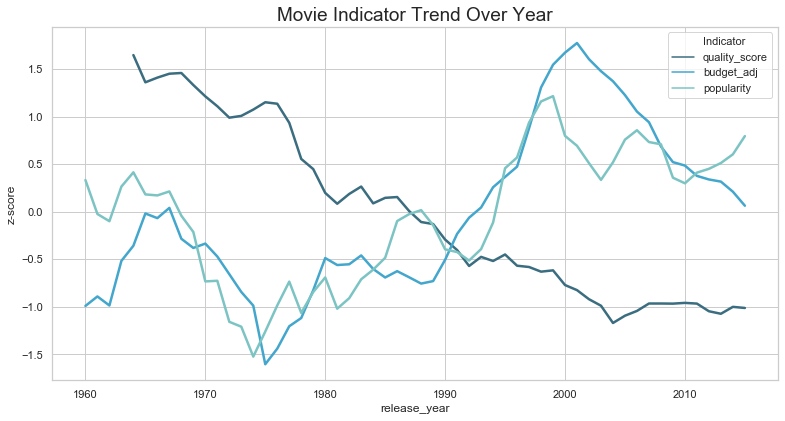

In [12]:
plt.figure(figsize=(13,6.5))
sns.set(style="whitegrid", color_codes=True)
sns.lineplot(x="release_year", y="z-score",
                  hue="Indicator", data=r1, palette="GnBu_d", linewidth=2.5)
plt.title("Movie Indicator Trend Over Year", size=19);

<span style="font-family:Arial; font-size:1.06em;"> The graph shows that movies quality has continued to **decline** from year to year and only has a direct correlation with the variable budget for the period 1960 to the mid-1970s. Conversely, budget variables have a strong correlation with popularity indicators and relatively increasing (last year budget higher than first year budget). This can indicate that a large amount of fund allocation pays the costs of promotion, advertising, or well-known actors as cast.</span>

### Research Question #2
> **1. Higher popularity equals to higher score of a movie?**

> **2. Higher budget production generate to higher score of a movie?**

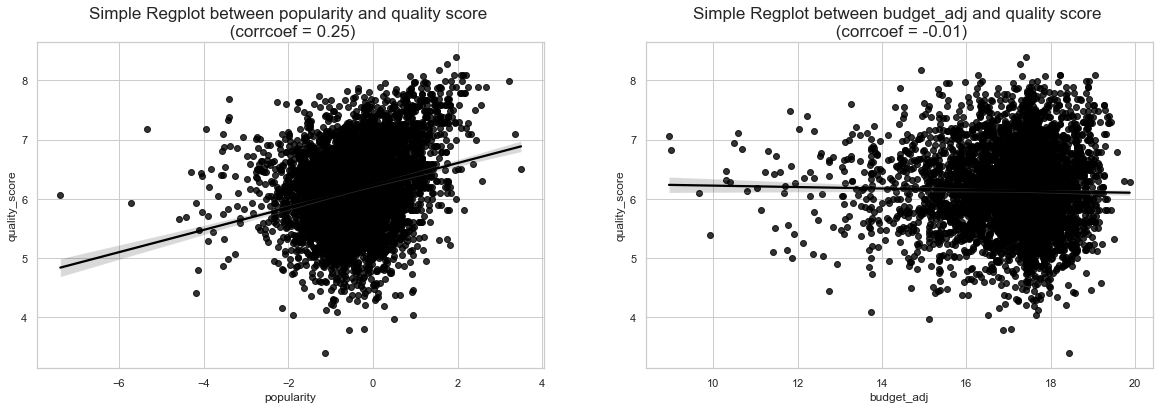

In [13]:
plt.figure(figsize=(20,6))

col = [23, "popularity", "budget_adj"]
for i in range(1,3):
    plt.subplot(1, 2, i)
    sns.regplot(y=df['quality_score'], x=np.log(df[col[i]]), robust=True, color="black"); #normalize distribution with log
    plt.title("Simple Regplot between {} and quality score \n (corrcoef = {})".format(col[i], round(
    np.corrcoef(df['quality_score'], np.log(df[col[i]]))[1,0], 2)), size=17);

In [14]:
#t-test 
stats.ttest_ind(df['quality_score'],df["popularity"], equal_var = False)

Ttest_indResult(statistic=293.3031465279463, pvalue=0.0)

In [15]:
#list of row which have low score but high budget
df[(df["quality_score"] < 5.2) & (df["budget_adj"] > 160000000)]

,original_title,popularity,production_companies,quality_score,budget_adj,release_year
3394,Green Lantern,2.419805,De Line Pictures,5.115586,1.938796e+08,2011
5236,Batman & Robin,2.604799,Polygram Filmed Entertainment,4.455067,1.698075e+08,1997
5257,Speed 2: Cruise Control,1.172353,Twentieth Century Fox Film Corporation,4.579649,2.173537e+08,1997
8997,Godzilla,1.170499,Tristar Pictures,5.142888,1.739004e+08,1998


In [16]:
#list of row which have high score with low budget
df[(df["quality_score"] > 7) & (df["budget_adj"] < 160000)]

,original_title,popularity,production_companies,quality_score,budget_adj,release_year
3755,Weekend,0.243777,Em Media,7.060696,7755.184341,2011
4192,Clerks,1.297355,Miramax Films,7.111011,39720.012163,1994
8923,Vincent,0.391453,Walt Disney Productions,7.478450,135578.544153,1982


<span style="font-family:Arial; font-size:1.06em;">In order to answer those question, I use regplot which can show the relationship each variable. **First one**, based on left graph, we can say that popularity have positive relationship with movie's score, but relatively weak. Moreover, if I conduct t-test between score and popularity variable, I will get significant reseult which mean those two variable different statisticaly. Thus, temporarily, we conclude that popularity can't be subsitute of score variable as a proxy of success a movie. While, for **second question** I tried to answer with the right graph, clearly show that the movie's score almost has no relationship with budget of movie production. In other word, large of budget production do not g uarantee the success of a movies, for example Batman & Robin and Godzilla spent app. $170 million, yet generated very low scores. Otherwise, like Vincent movies spent less budget, up to one thousand times, have relatively high score though less popular.</span>

### Research Question #2
> **Are there some companies more likely produce successful movie?** I will compare only top three production companies sample, Universal, Paramount, and Columbia, take into account large of production companies (1628 nunique value in df dataset).

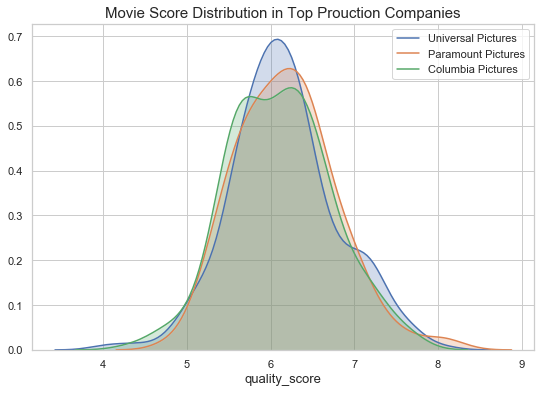

In [17]:
topthree = ["Universal Pictures", "Paramount Pictures", "Columbia Pictures"]

plt.figure(figsize=(9,6))
plt.title("Movie Score Distribution in Top Prouction Companies", size=15)
plt.xlabel("quality_score", size=13)
for i in topthree:
    sns.kdeplot(df.loc[(df["production_companies"] == i), "quality_score"], shade=True, label=i);

In [18]:
#I use median because only score have normal distribution
df.groupby("production_companies")[["quality_score", "budget_adj", "popularity"]].median().loc[topthree]

,quality_score,budget_adj,popularity
production_companies,,,
Universal Pictures,6.096601,4.056560e+07,0.843170
Paramount Pictures,6.161790,4.366530e+07,0.743143
Columbia Pictures,6.096299,4.902159e+07,0.877654


<span style="font-family:Arial; font-size:1.06em;"> In term of score alone, among those three movie production companies slightly have same median and distribution. However, if I include budget variable in analysis, Universal Pictures has a more efficient budget than Columbia Pictures and Paramount Pictures with lower budget to get the same output in score or popularity. Moreover, connect to the first research question, popularity column show that Columbia Pictures apparently poured a lot of budget portion into advertising in order to gain popularity before movie release date.</span>

<a id='conclusions'></a>
## Conclusions

> <span style="font-family:Arial; font-size:1.06em;">In summarize, therefore, higher budget nor more popular some movies **not necessarily** get a high score, indeed they have week relationship. In fact, the budget varible have strong relationship with the movie popularity, for example that Columbia Pictures spent a lot of budget portion into advertising in order to gain popularity before movie release date than Universal Pictures and Paramount Pictures. However, Universal Pictures has a more efficient budget speding.</span>

> **Disclaimer**: This invesigation mostly utilize descriptive statistics. I can't be certain that this relationship has a causal relationship. In Addition, I just use few columns in analysis process and average_voting (subjective score) as my only dependent variable.